# TODO
- feature engineering sur la datetime (add year, season, weeknumber)
- LSTM w/ Keras
- ARIMA & SARIMA Model
- use KNN to interpolate

In [1]:
%matplotlib inline
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import sys, os

import sklearn.preprocessing as pp
import sklearn.decomposition as decomposition
# import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error

# import sklearn.svm as svm
import sklearn.ensemble as ensemble
import sklearn.neighbors as neighbors
import xgboost as xgb

sys.path.append('../')
# import lib.tools
pd.options.display.max_columns = 50

/home/greg/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
raw_path = '../data/raw/'

# First approach : prediction by removing Nan rows

## Data Preprocessing

In [3]:
def season(df):
    df['month'] = df.index.month
    season_col = df['month']
    season_col = season_col.replace([12, 1, 2], 0)
    season_col = season_col.replace([3, 4, 5], 1)
    season_col = season_col.replace([6, 7, 8], 2)
    season_col = season_col.replace([9, 10, 11], 3)
    ohc = pd.DataFrame(np.eye(4)[season_col], columns=['winter', 'spring', 'summer', 'fall'], index=df.index)
    return pd.concat([df, ohc], axis=1)

used_var = ['ffH10', 'flir1SOL0', 'fllat1SOL0', 'flsen1SOL0',
       'flvis1SOL0', 'hcoulimSOL0', 'huH2', 'iwcSOL0', 'nbSOL0_HMoy',
       'nH20', 'ntSOL0_HMoy', 'pMER0', 'rr1SOL0', 'tH2',
            'tH2_VGrad_2.100', 'tH2_XGrad', 'tH2_YGrad', 'tpwHPA850', 'ux1H10',
            'vapcSOL0', 'vx1H10']

In [4]:
def processing(filename = 'train_1', drop_method = 'any'):
    data = pd.read_csv(raw_path + filename + '.csv', header=0, delimiter=';',decimal=',',
                        parse_dates=['date'], index_col='date')
    
    data = data.rename(columns={'mois':'month'})
    raw_colnames = list(data.columns.values)

    # Add lag operator (shift ce fait par ville)
    groupby_cities = data.groupby('insee')
    shift = groupby_cities.tH2.shift(1)
    data['tH2_lag1'] = shift
    
    # Add temporal features
    # data['week'] = data.index.week # WEEK AS CATEGORY ?
    data = season(data) # add season 
    data.drop(['month'], inplace=True, axis=1)
    
    # Variables to be dropped
    data.drop(['capeinsSOL0', 'ciwcH20', 'clwcH20'], inplace=True, axis=1)
    
    #Transform to dummy
    dummies = ['ddH10_rose4', 'insee', 'month']
    df_dummy = pd.get_dummies(data, columns=dummies, prefix=dummies)
    data.drop(['ddH10_rose4'], inplace=True, axis=1)
    
    # Drop NAN
    data.dropna(how=drop_method, axis=0, inplace=True)
    data.drop(['insee'], inplace=True, axis=1)
    return data, [x for x in raw_colnames if x not in dummies]
file_, raw_col = processing()
#assert nb de col is good

In [5]:
file_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5803 entries, 2014-01-02 to 2016-05-30
Data columns (total 29 columns):
tH2_obs            5803 non-null float64
ffH10              5803 non-null float64
flir1SOL0          5803 non-null float64
fllat1SOL0         5803 non-null float64
flsen1SOL0         5803 non-null float64
flvis1SOL0         5803 non-null float64
hcoulimSOL0        5803 non-null float64
huH2               5803 non-null float64
iwcSOL0            5803 non-null float64
nbSOL0_HMoy        5803 non-null float64
nH20               5803 non-null float64
ntSOL0_HMoy        5803 non-null float64
pMER0              5803 non-null float64
rr1SOL0            5803 non-null float64
rrH20              5803 non-null float64
tH2                5803 non-null float64
tH2_VGrad_2.100    5803 non-null float64
tH2_XGrad          5803 non-null float64
tH2_YGrad          5803 non-null float64
tpwHPA850          5803 non-null float64
ux1H10             5803 non-null float64
vapcSOL0      

In [5]:
file_.describe(include='all')

,tH2_obs,capeinsSOL0,ciwcH20,clwcH20,ffH10,flir1SOL0,fllat1SOL0,flsen1SOL0,flvis1SOL0,hcoulimSOL0,huH2,iwcSOL0,nbSOL0_HMoy,nH20,ntSOL0_HMoy,pMER0,rr1SOL0,rrH20,tH2,tH2_VGrad_2.100,tH2_XGrad,tH2_YGrad,tpwHPA850,ux1H10,vapcSOL0,vx1H10,ech,winter,spring,summer,fall,tH2_obs_lag1
count,5320.000000,5320.000000,5.320000e+03,5320.000000,5320.000000,5320.000000,5.320000e+03,5320.000000,5.320000e+03,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.0,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,10.794850,38.156226,6.153249e-08,0.000005,3.045502,-188232.663376,-3.039608e+04,41001.537938,3.600000e-12,303.033862,82.757718,0.019854,2.158567,0.263755,4.688112,1016.799651,0.082771,0.003301,11.007913,0.978006,0.001718,0.000153,9.720496,1.134970,18.054829,0.570248,1.0,0.269737,0.300000,0.211842,0.218421,10.787124
std,5.644472,105.920034,1.265848e-06,0.000034,1.925344,93330.633218,8.053257e+04,74272.584916,4.039347e-28,370.060776,11.911368,0.355182,2.894930,1.261420,3.331863,8.752835,0.498831,0.022012,5.885340,1.931295,0.002731,0.003616,4.655218,4.249642,8.116949,4.426616,0.0,0.443865,0.458301,0.408652,0.413213,5.636041
min,-6.100000,0.000000,0.000000e+00,0.000000,0.008230,-503863.736917,-1.453469e+06,-222339.901199,3.600000e-12,0.466309,15.270923,0.000000,0.000000,0.000000,0.000000,982.386670,0.000000,0.000000,-6.967169,-1.794131,-0.011979,-0.017866,-3.398325,-21.681247,1.305881,-14.486823,1.0,0.000000,0.000000,0.000000,0.000000,-6.100000
25%,6.800000,0.000000,0.000000e+00,0.000000,1.747434,-254259.481491,-3.697732e+04,-2325.087340,3.600000e-12,47.077669,76.473229,0.000000,0.000000,0.000000,0.684354,1011.637320,0.000000,0.000000,6.727558,-0.499713,0.000135,-0.000899,6.402043,-1.324982,11.716861,-2.545561,1.0,0.000000,0.000000,0.000000,0.000000,6.800000
50%,10.500000,1.051056,0.000000e+00,0.000000,2.611776,-206380.229047,-5.008594e+02,21208.576631,3.600000e-12,160.157757,85.245933,0.000000,0.311480,0.000000,5.922766,1017.068176,0.000000,0.000000,10.853752,0.342886,0.001211,0.000362,9.609577,1.055253,16.994681,0.305365,1.0,0.000000,0.000000,0.000000,0.000000,10.500000
75%,14.500000,20.403417,0.000000e+00,0.000000,3.833263,-118867.921605,6.860203e+03,71389.670491,3.600000e-12,417.854110,91.685597,0.000000,4.141728,0.000000,7.995934,1022.387789,0.000000,0.000000,14.971403,2.028461,0.003065,0.001909,13.068447,3.187833,23.208885,3.254086,1.0,1.000000,1.000000,0.000000,0.000000,14.500000
max,29.799999,1083.809402,4.305547e-05,0.000413,15.310204,78624.299681,9.387913e+04,641199.521351,3.600000e-12,3123.016425,99.997908,10.107500,8.000000,8.331533,8.000000,1043.259009,14.344218,0.727914,30.683831,11.169983,0.019835,0.014316,21.767814,23.799293,53.544544,22.807208,1.0,1.000000,1.000000,1.000000,1.000000,29.799999


In [6]:
file_.head(10)

,tH2_obs,capeinsSOL0,ciwcH20,clwcH20,ffH10,flir1SOL0,fllat1SOL0,flsen1SOL0,flvis1SOL0,hcoulimSOL0,huH2,iwcSOL0,nbSOL0_HMoy,nH20,ntSOL0_HMoy,pMER0,rr1SOL0,rrH20,tH2,tH2_VGrad_2.100,tH2_XGrad,tH2_YGrad,tpwHPA850,ux1H10,vapcSOL0,vx1H10,ech,winter,spring,summer,fall,tH2_obs_lag1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,7.9,2.588260,0.0,0.0,2.608449,-154865.268269,-123893.703248,-55913.162861,3.600000e-12,149.373482,84.961316,0.0,5.483689,0.0,7.209474,1016.285475,0.000149,0.000011,10.600003,-0.337017,0.001096,-0.004172,8.109257,0.809966,17.077868,-4.782408,1,1.0,0.0,0.0,0.0,5.5
2014-01-02,9.9,0.777403,0.0,0.0,4.282281,-140018.547252,-20709.302019,129016.229110,3.600000e-12,2017.266169,86.036733,0.0,5.099234,0.0,8.000000,1008.707113,0.046678,0.023633,9.768346,0.051136,0.001342,0.000109,10.796253,-7.049838,21.103269,6.360897,1,1.0,0.0,0.0,0.0,4.8
2014-01-02,10.9,83.283533,0.0,0.0,5.661406,-95081.575267,-180224.080318,268398.808876,3.600000e-12,407.454874,90.019000,0.0,7.201289,0.0,7.967715,1004.907730,0.174213,0.009263,11.113807,-0.158892,0.001357,0.000166,9.951490,14.156426,19.419304,0.263937,1,1.0,0.0,0.0,0.0,8.9
2014-01-02,10.4,136.048826,0.0,0.0,8.379668,-103235.862329,-208537.406156,327814.670027,3.600000e-12,992.654513,84.323883,0.0,6.105693,0.0,7.778396,993.093515,0.068039,0.000000,10.526658,-0.078173,0.000749,0.000212,9.572578,8.191206,17.340387,13.215906,1,1.0,0.0,0.0,0.0,6.8
2014-01-02,9.8,3.438741,0.0,0.0,10.567909,-16301.921954,-144263.136709,225936.035640,3.600000e-12,1111.632573,90.472259,0.0,8.000000,0.0,8.000000,992.159175,0.002412,0.000003,9.609188,-0.435701,-0.000061,-0.000072,9.525607,1.853062,18.763619,16.945114,1,1.0,0.0,0.0,0.0,5.4
2014-01-02,7.1,0.000000,0.0,0.0,4.662978,-69724.401757,-37954.551133,84376.214114,3.600000e-12,195.119326,85.623929,0.0,0.780766,0.0,8.000000,1006.652854,0.038399,0.018949,6.038611,0.894173,-0.001286,0.000375,9.418620,0.688429,18.145468,6.621457,1,1.0,0.0,0.0,0.0,2.9
2014-01-02,10.8,4.912787,0.0,0.0,7.950356,-29124.119096,-91982.124000,143723.896376,3.600000e-12,1185.035828,80.824950,0.0,8.000000,0.0,8.000000,994.643040,0.028867,0.000000,11.327767,-0.696313,0.000755,0.001668,10.387874,4.607462,18.776568,16.027232,1,1.0,0.0,0.0,0.0,7.0
2014-01-03,9.1,0.219066,0.0,0.0,0.743717,-237180.748754,-53512.199638,-23413.425466,3.600000e-12,286.201951,87.566311,0.0,4.941245,0.0,7.655754,1016.179675,0.000000,0.000000,12.007224,-0.596205,0.004342,-0.006993,9.721419,1.018976,16.333999,-3.865133,1,1.0,0.0,0.0,0.0,7.9
2014-01-03,11.5,12.982000,0.0,0.0,3.444289,-79146.819594,-83373.239818,159044.254867,3.600000e-12,358.955019,74.879747,0.0,5.305447,0.0,7.999932,1012.244925,0.077871,0.019661,10.743082,0.373917,0.003214,-0.000007,12.166747,-3.439840,24.122176,8.130328,1,1.0,0.0,0.0,0.0,9.9


## Factor Analysis

In [7]:
# file_['2014-01'][]
# calculer la variation moyenne de temperature en de décembre à janvier pour estimer 2014-01-01

Normalize float data

In [ ]:
pp.Normalizer().fit_transform(file_[raw_col]) #normalize only original float columns

In [98]:
# assert no nan
fa = decomposition.FactorAnalysis().fit(file_.drop('tH2_obs'))

In [99]:
fa

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

## ML

In [7]:
seed = 1
results_dict = dict()
predictions_dict = dict()

In [9]:
models = []
# models.append(('CART', tree.DecisionTreeRegressor()))
models.append(('RF', ensemble.RandomForestRegressor(n_estimators=40, n_jobs=3,bootstrap=False)))
models.append(('GB', ensemble.GradientBoostingRegressor(n_estimators=40, )))
# models.append(('NB'), ) # Naive Bayes for modeling uncertainty
# LSTM
# models.append(('XGB', xgb.XGBRegressor()))

# poor results
# models.append(('KNN', neighbors.KNeighborsRegressor(n_jobs=3)))
# models.append(('SVM', svm.SVR()))

# for name, model in models:
#     results_dict[name] = {}
    

Apply forward walk

In [10]:
first_train = True
for i in range(1,36):
    print(i)
    train_file = 'train_' + str(i)
    test_file = 'train_' + str(i+1)
    
    x_test, tmp = processing(filename=test_file)
    y_test = pd.DataFrame(x_test.tH2_obs)
    x_test = x_test.drop('tH2_obs', axis=1)
    
    train, raw_col_names = processing(train_file)
    if first_train is True:
        x_train = train.drop('tH2_obs', axis=1)
        y_train = train.pop('tH2_obs')
        first_train = False
    else:
        x_train = pd.concat([x_train, train.drop('tH2_obs', axis=1)])
        y_train = pd.concat([y_train, train.pop('tH2_obs')])
        
    for name, model in models: 
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        result = np.sqrt(mean_squared_error(y_test, pred))
        
        # revoir structure
        if name in results_dict:
            results_dict[name].append(result)
            predictions_dict[name].append(pred)
        else:
            results_dict[name] = [result]
            predictions_dict[name] = [pred]
        print(name, ' : ', result)

1
RF  :  1.0765401019
GB  :  0.930086243689
2
RF  :  1.10786269975
GB  :  0.991283459009
3
RF  :  1.15190647796
GB  :  1.03072197058
4
RF  :  1.23134239669
GB  :  1.07332614201
5
RF  :  1.29474522405
GB  :  1.11651830297
6
RF  :  1.32724579791
GB  :  1.17886315625
7
RF  :  1.42900412806
GB  :  1.20212883161
8
RF  :  1.52138325056
GB  :  1.25527310264
9
RF  :  1.58383088283
GB  :  1.30501010459
10
RF  :  1.6694635516
GB  :  1.40669271185
11
RF  :  1.70513322444
GB  :  1.45876678156
12
RF  :  1.6906028441
GB  :  1.50417240578
13
RF  :  1.68790341575
GB  :  1.49295512911
14
RF  :  1.67790183308
GB  :  1.47618262743
15
RF  :  1.70740092801
GB  :  1.41748665757
16
RF  :  1.69985236475
GB  :  1.35320008011
17
RF  :  1.61177790379
GB  :  1.25323764186
18
RF  :  1.5584046243
GB  :  1.19825511207
19
RF  :  1.49705621975
GB  :  1.19288881694
20
RF  :  1.46777974163
GB  :  1.22945832903
21
RF  :  1.47408506382
GB  :  1.25140023524
22
RF  :  1.49847042599
GB  :  1.26782709182
23
RF  :  1.496340894

IOError: File ../data/raw/train_37.csv does not exist

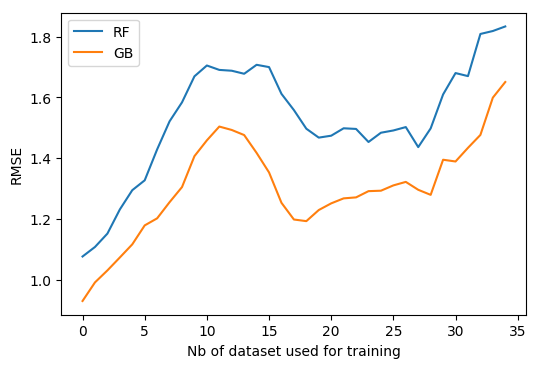

In [36]:
plt.figure(dpi=100)
for key, val in results_dict.iteritems():
    plt.plot(range(len(val)), val, '-', label=key)
plt.ylabel("RMSE")
plt.xlabel("Nb of dataset used for training")
plt.legend()
plt.show()

I dont keep CART, SVM, KNN  
KNN and SVM : computational time too long  
CART : results not satisfying

# Feature importance

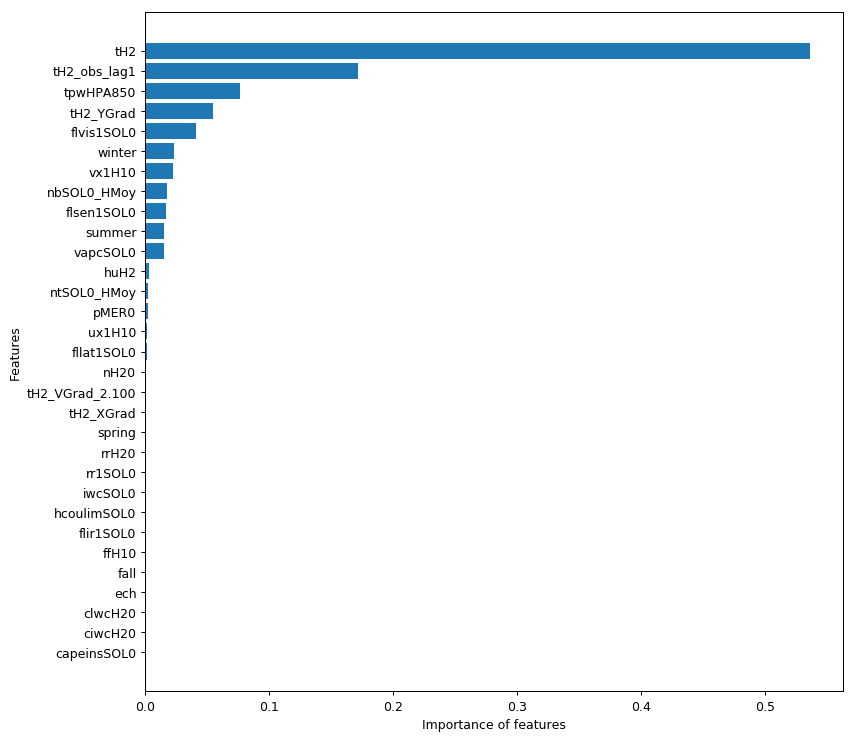

In [38]:
plt.figure(dpi=90, figsize=(10, 10))
imp = models[1][1].feature_importances_

imp, names = zip(*sorted(zip(imp, x_train.columns.values)))

plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)),names)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.show()

plt.show()

In [29]:
for imp_, name in zip(imp, names):
    print(name, imp_)

capeinsSOL0 0.0
ciwcH20 0.0
clwcH20 0.0
ech 0.0
fall 0.0
ffH10 0.0
flir1SOL0 0.0
hcoulimSOL0 0.0
iwcSOL0 0.0
rr1SOL0 0.0
rrH20 0.0
spring 0.0
tH2_XGrad 0.0
tH2_VGrad_2.100 0.000473185640091
nH20 0.000646042212251
fllat1SOL0 0.00123987020174
ux1H10 0.00165442158361
pMER0 0.00196462866588
ntSOL0_HMoy 0.00208249522193
huH2 0.00312947768009
vapcSOL0 0.014887148468
summer 0.0151872948003
flsen1SOL0 0.0169302477277
nbSOL0_HMoy 0.0171657243592
vx1H10 0.0223903288434
winter 0.0232225651349
flvis1SOL0 0.0412978957912
tH2_YGrad 0.0545171844959
tpwHPA850 0.0761312213813
tH2_obs_lag1 0.171257672117
tH2 0.535822595676


low importance : 
- capeinsSOL0
- ciwcH20
- clwcH20
- ffH10
- flir1SOL0
- hcoulimSOL0
- iwcSOL0
- rr1SOL0
- rrH20
- tH2_XGrad
- tH2_VGrad_2.100
- nH20
- fllat1SOL0
- ux1H10

## Feature engineering

### TODO
- Travail d'une force : vitesse * direction  
https://fr.wikipedia.org/wiki/Travail_d%27une_force


# Draft

In [29]:
groupby_cities = file_.groupby('insee')

Moving Average

In [30]:
pd.DataFrame(groupby_cities.tH2_obs.rolling(window=2).mean()) # ?

tH2_obs
insee    date                 
31069001 2014-01-01        NaN
         2014-01-02   7.350000
         2014-01-03  10.700000
         2014-01-04   9.900000
         2014-01-05   6.800000
         2014-01-06   6.950000
         2014-01-07   9.750000
         2014-01-08  11.150000
         2014-01-09  11.450000
         2014-01-10   9.550000
         2014-01-11   8.650000
         2014-01-12   9.900000
         2014-01-13   9.750000
         2014-01-14   6.000000
         2014-01-15   3.950000
         2014-01-16   6.350000
         2014-01-17   5.500000
         2014-01-18   3.450000
         2014-01-19   3.350000
         2014-01-20   4.700000
         2014-01-21   5.600000
         2014-01-22   3.300000
         2014-01-23   4.050000
         2014-01-24   7.650000
         2014-01-25   9.700000
         2014-01-26  10.550000
         2014-01-27  10.150000
         2014-01-28   6.700000
         2014-01-29   4.650000
         2014-01-30   5.100000
...                        ...
75114001 2016-05-01   7.050000
         2016-05-02   7.400000
         2016-05-03   9.950000
         2016-05-04  10.000000
         2016-05-05  10.150000
         2016-05-06  12.350000
         2016-05-07  14.300000
         2016-05-08  15.700000
         2016-05-09  16.900000
         2016-05-10  16.550000
         2016-05-11  15.050000
         2016-05-12  14.600000
         2016-05-13  14.450000
         2016-05-14  12.500000
         2016-05-15   9.050000
         2016-05-16   9.550000
         2016-05-17  10.750000
         2016-05-18  12.250000
         2016-05-19  11.900000
         2016-05-20  10.900000
         2016-05-21  13.650000
         2016-05-22  15.300000
         2016-05-23  13.450000
         2016-05-24  10.900000
         2016-05-25  10.050000
         2016-05-26  11.400000
         2016-05-27  15.000000
         2016-05-28  16.750000
         2016-05-29  16.650001
         2016-05-30  15.850000

[6167 rows x 1 columns]

Interpolate NA val

In [ ]:
groupby_city.capeinsSOL0.apply(pd.Series.interpolate)

# Documentation

- Handling missing val for RF  
https://stats.stackexchange.com/questions/98953/why-doesnt-random-forest-handle-missing-values-in-predictors/186264#186264  https://github.com/scikit-learn/scikit-learn/issues/5870  